## osumapper: create osu! map using Tensorflow and Colab

### Model Training

Github: https://github.com/kotritrona/osumapper

### Step 0: Installation

First of all, check the Notebook Settings under Edit tab.<br>
Activate GPU to make the training faster.

Then, clone the git repository and install dependencies.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Joe's cell
DRIVE_PATH = 'drive/MyDrive/Cal/Colab/DeepMusicVisualizer'

In [ ]:
# Richard's cell
DRIVE_PATH = 'drive/MyDrive/cs194/DeeperMusicVisualizer'

In [3]:
%cd $DRIVE_PATH

/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer


In [4]:
%cd rhythm

/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/rhythm


In [5]:
#%cd /content/
#!git clone https://github.com/kotritrona/osumapper.git
#%cd osumapper/v7.0
!apt install -y ffmpeg
!apt install -y nodejs
#!cp requirements_colab.txt requirements.txt
#!cp package_colab.json package.json
!pip install -r requirements_colab.txt
!npm install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libc-ares2 nodejs-doc
The following NEW packages will be installed:
  libc-ares2 nodejs nodejs-doc
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 5,585 kB of archives.
After this operation, 24.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 nodejs-doc all 8.10.0~dfsg-2ubuntu0.4 [752 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libc-ares2 amd64 1.14.0-1 [37.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 nodejs amd64 8.10.0~dfsg-2ubuntu0.4 [4,796 kB]
Fetched 5,585 kB in 1s (5,974 kB/s)
Sel

### Step 1: Upload training maps

Write the maplist.txt and run the first block of `01_Training.ipynb` (`act_data_prep.step1_load_maps()`) locally.<br>
After that, make a folder `NPZ/` under your google drive, and upload the generated npz files under local `mapdata/` in there.

In [6]:
# Wait for the upload to finish
from act_data_prep import *
# for osu!mania use this instead of above
# from mania_act_data_prep import * 
step1_load_maps();

Number of filtered maps: 5
Map data #0 saved! time = 5.314159393310547 secs
Map data #1 saved! time = 2.307966709136963 secs
Map data #2 saved! time = 2.2577977180480957 secs
Map data #3 saved! time = 2.3788866996765137 secs
Map data #4 saved! time = 2.3308141231536865 secs


Mount your google drive in Colaboratory.<br>
It will ask you for an auth code.


In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

Copy .npz files to the training data folder.

In [ ]:
# One of mkdir or rm will pop an error. Ignore it.
#!mkdir mapdata/
#!rm mapdata/*.npz
#!cp /gdrive/'My Drive'/NPZ/*.npz mapdata/
#print("Copy complete!")

In [7]:
%load_ext autoreload
%autoreload 2

## Step 2: rhythm model

(after this point it's copypaste from `01_Training.ipynb` from the second block)

Train a rhythm model that decides where to place circles/sliders based on music.

If you're using GPU and it reports a memory error, try setting batch_size parameter to a smaller value (that GPU can handle).

In [8]:
from act_train_rhythm import *

train_params = {
    "divisor" : 4,
    "train_epochs" : 32,
    "train_batch_size" : None, # Default is 32 or based on machine specs
    "plot_history" : True,
    "too_many_maps_threshold" : 240,
    "train_epochs_many_maps" : 6,
    "data_split_count" : 80
};
model = step2_build_model()

daata (1101, 7, 32, 2) (1101, 7, 32, 2)
label (1101, 8) (1101, 5)


Train the model and evaluate.
is_note_start accuracy should be about 0.8 to 0.9 based on my tests, others should be lower.

**Note:** I changed the metrics from F1 to AUC in this version!! 0.5=guessing 1=perfect for AUC

daata (1101, 7, 32, 2) (1101, 7, 32, 2)
label (1101, 8) (1101, 5)
daata (5505, 7, 32, 2) (5505, 7, 32, 2)
label (5505, 8) (5505, 5)
preprocessed data (344, 16, 7, 32, 2)
preprocessed div (344, 16, 7)
preprocessed label (344, 16, 5)
final train labels AFTER validation split (111, 16, 5)
final train data AFTER validation split (111, 16, 7, 32, 2)

................................

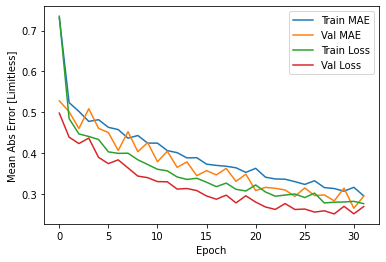

daata (1101, 7, 32, 2) (1101, 7, 32, 2)
label (1101, 8) (1101, 5)
is_note_start auc score: 0.9480216120145099
is_circle auc score: 0.8877501522705638
is_slider auc score: 0.9259380811727383
is_note_end auc score: 0.874554817059376


In [23]:
# %reload_ext autoreload
from act_train_rhythm import *

model = step2_train_model(model, train_params)
step2_evaluate(model)

Done! now save the model to the disk.

In [ ]:
from google.colab import files
step2_save(model)

files.download("saved_rhythm_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 3: flow dataset construction

Construct a dataset for the map flow generator.

In [ ]:
from act_flow_ds import *;

flow_dataset_params = step3_set_params(note_group_size=10, step_size=5);
maps_flow = step3_read_maps_flow(flow_dataset_params);
step3_save_flow_dataset(maps_flow);
files.download("flow_dataset.npz")

# hitsounds dataset, only for taiko maps
# maps_hs_af, maps_hs = step3_read_maps_hs(flow_dataset_params);
# step3_save_hs_dataset(maps_hs_af, maps_hs);
# files.download("hs_dataset.npz")

# pattern dataset, only for mania (remove the flow part for mania)
# data = step3_read_maps_pattern([]);
# step3_save_pattern_dataset(data);
# files.download("mania_pattern_dataset.npz")

Replace the default model files to use it in Colab map creator.

In [ ]:
!cp saved_rhythm_model models/default/rhythm_model
!cp flow_dataset.npz models/default/flow_dataset.npz
# !cp hs_dataset.npz models/default/hs_dataset.npz
# !cp mania_pattern_dataset.npz models/default/mania_pattern_dataset.npz

That's it! The models are trained. Start making a new map with the other notebook.

For bug reports and feedbacks either report it on github or use discord: <br>
[https://discord.com/invite/npmSy7K](https://discord.com/invite/npmSy7K)